In [18]:
import numpy as np
import astropy.units as u
import yaml
import h5py
from astropy.constants import G
import gala.integrate as gi
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
import gala.units as gu
from gala.units import galactic
import os.path
import sys
from argparse import ArgumentParser
import pathlib
from scipy.spatial.transform import Rotation
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

In [19]:
print("loading mwlmc model...")
from mwlmc import model as mwlmc_model
print("mwlmc_model has been called...")
Model = mwlmc_model.MWLMC()
print("mwlmc model successfully loaded and set!")

loading mwlmc model...
mwlmc_model has been called...
Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!
mwlmc model successfully loaded and set!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [59]:
def fill_with_zeros(arr, m):
    n = arr.shape[0]
    if m <= n:
        return arr
    else:
        filled_arr = np.full((m, 3), np.nan)
        filled_arr[:n, :] = arr
        return filled_arr
    
def fill_with_nans_1d(arr, m):
    n = arr.shape[0]
    if m <= n:
        return arr
    else:
        filled_arr = np.full(m, np.nan)
        filled_arr[:n] = arr
        return filled_arr

def num_summedforces(t, progxs, mwdharmonicflag, mwhharmonicflag, lmcharmonicflag, motion):
    
    x0 = np.array(Model.expansion_centres(t))
    if motion == False:
        x0 *= 0 
    # disk 
    acc_disk = Model.mwd_fields(t, 
                                progxs[0, None].value - x0[:3][0, None],
                                progxs[1, None].value - x0[:3][1, None],
                                progxs[2, None].value - x0[:3][2, None],
                                mwdharmonicflag)[ :3]
    # halo
    acc_halo = Model.mwhalo_fields(t, 
                                   progxs[0, None].value - x0[3:6][0, None],
                                   progxs[1, None].value - x0[3:6][1, None],
                                   progxs[2, None].value - x0[3:6][2, None],
                                   mwhharmonicflag)[ :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, 
                               progxs[0, None].value - x0[6:9][0, None],
                               progxs[1, None].value - x0[6:9][1, None],
                               progxs[2, None].value - x0[6:9][2, None],
                               lmcharmonicflag)[ :3]

    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    
    return accs

def numerical_forceDerivs(positions, t, mwhflag, mwdflag, lmcflag, motion, epsilon=1e-4):
    
    """
    numerical_forceDerivs - takes the positions for the mock stream progenitor and returns the derivatives of the forces for each position 
                    and second derivative of the potential w.r.t the positons.
    
    Inputs
    - positions: The positions of the progenitor in kpc, Shape N x 3.
    - ts: Time steps corresponding to each position in Gyr.
    - mwhflag: flag to set which mw halo expansion orders to be non-zero.
    - mwdflag: flag to set which mw disc expansion orders to be non-zero.
    - lmcflag: flag to set which lmc halo expansion orders to be non-zero.
    - motion: flag to allow motion of the MW disc and halo.
    - epsilon: (optional) The small value away from each position used find the derivative in kpc. Default is 0.01pc
    
    Retuns
    - Hess: The Hessian matrix of all force derivatives. Shape (len(times), 3, 3). ((xx, xy, xz), 
                                                                                    (yx, yy, yz), 
                                                                                    (zx, zy, zz))
    - d2Phi_d2r: The second derivative of the potential with repect to the position.
    """
    
    r_prog = np.linalg.norm(positions)
    
    fxx_yx_zx = np.zeros(shape=(1,3))
    fxy_yy_zy = np.zeros(shape=(1,3))
    fxz_yz_zz = np.zeros(shape=(1,3))
    
    positions *= u.kpc
    positions_dx = (positions + np.array([epsilon,0.,0.])*u.kpc )
    positions_dy = (positions + np.array([0.,epsilon,0.])*u.kpc )
    positions_dz = (positions + np.array([0.,0.,epsilon])*u.kpc )
    
    fxx_yx_zx = (num_summedforces(t, positions_dx, mwdflag, mwhflag, lmcflag, motion) - num_summedforces(t, positions, mwdflag, mwhflag, lmcflag, motion) ) \
                    / np.linalg.norm(positions_dx - positions)
        
    fxy_yy_zy = (num_summedforces(t, positions_dy, mwdflag, mwhflag, lmcflag, motion) - num_summedforces(t, positions, mwdflag, mwhflag, lmcflag, motion) ) \
                    / np.linalg.norm(positions_dy - positions)
        
    fxz_yz_zz = (num_summedforces(t, positions_dz, mwdflag, mwhflag, lmcflag, motion) - num_summedforces(t, positions, mwdflag, mwhflag, lmcflag, motion) ) \
                    / np.linalg.norm(positions_dz - positions)
        
    Hess = np.zeros((1, 3, 3))
    Hess[:, 0, :] = -np.array([fxx_yx_zx[:, 0], fxy_yy_zy[:, 0], fxz_yz_zz[:, 0]]).T
    Hess[:, 1, :] = -np.array([fxx_yx_zx[:, 1], fxy_yy_zy[:, 1], fxz_yz_zz[:, 1]]).T
    Hess[:, 2, :] = -np.array([fxx_yx_zx[:, 2], fxy_yy_zy[:, 2], fxz_yz_zz[:, 2]]).T
    
    r_hat = positions.reshape(1,3) / r_prog.reshape(1,)
    d2Phi_d2r = np.einsum('ki,kij,kj->k', r_hat, Hess, r_hat)
    
    return d2Phi_d2r.value*(u.km**2/(u.s**2*u.kpc**2))

def gala_F(t, w, mwdflag, mwhflag, lmcflag, motion):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    if motion==False:
        x0 *= 0 
    # disk
    acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=mwdflag)[:, :3]
    # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
    # acc_disk = MiyamotoNagai.acceleration(w[:3, :] - x0[:3, None]).to((u.km**2/(u.s**2*u.kpc))).value.T
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=mwhflag)[:, :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=lmcflag)[:, :3]
    
    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))

def gala_rewind(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag, motion):
    
    integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    # integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    if motion==False:
        mwd_x0 *= 0
        mwd_v0 *= 0
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)
    # subtract these off
    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    if motion==False:
        disk_x0 *= 0
        disk_v0 *= 0
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

def local_veldis(lons, vfs):
    # Compute percentiles
    lower_value = np.nanpercentile(lons, 5)
    upper_value = np.nanpercentile(lons, 95)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] #excludes progenitor [1:]
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute absolute velocity norms
    vfs_absol = np.linalg.norm(vfs_mainbody, axis=1)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_veldis = np.array([np.std(vfs_absol[m]) for m in mask.T])
    return np.nanmedian(local_veldis)

def lagrange_cloud_strip_adT(params):  

    print(params)
    
    fc, Mprog, a_s, Tbegin, Tfinal, dtmin, \
    mwhflag, mwdflag, lmcflag, strip_rate, \
    static_mwh, static_mwd, lmc_switch, motion = params
    
    print("Begining stream generation process...")
    
    new_G = G.to(u.kpc*(u.km/u.s)**2/u.Msun)
    Lunits = (u.kpc*u.km)/u.s
    max_steps = int((Tfinal - Tbegin) / dtmin) + 2 
    max_particles = int( ((max_steps)*strip_rate) + 1)
    
    if static_mwh==True:
        _, MWHcoeffs = Model.return_mw_coefficients()
        MWHcoeffs = np.array(MWHcoeffs)
        MWHcoeffs[:,0] = MWHcoeffs[:,0][0] 
        MWHcoeffs[:,1:] = MWHcoeffs[:,1:]*0
        Model.install_mw_coefficients(MWHcoeffs)
        print("MWH has been set to rigid!")
        #Some line of code here to check they have been set to zero and reinstalled
        _, MWHcoeffs = Model.return_mw_coefficients()
        assert np.allclose(np.array(MWHcoeffs)[:,1:],0)==True, "MW halo coefficients need to be set to zero"
        
    if static_mwd==True:
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        MWDctmp, MWDstmp = np.array(MWDctmp), np.array(MWDstmp)
        MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0], MWDstmp[:,0][0] # Turn this on to get static monopole disc 
        MWDctmp[:,1:], MWDstmp[:,1:] = MWDctmp[:,1:]*0, MWDstmp[:,1:]*0
        Model.install_disc_coefficients(MWDctmp,MWDstmp)
        print("MWD has been set to rigid!")
        #Some line of code here to check they have been set to zero and reinstalled.
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        assert np.allclose(np.array(MWDctmp)[:,1:],0)==True, "MW disc coefficients (c) need to be set to zero"
        assert np.allclose(np.array(MWDstmp)[:,1:],0)==True, "MW disc coefficients (s) need to be set to zero"
        
    if lmc_switch==True:
        _, LMCcoeffs = Model.return_lmc_coefficients()
        LMCcoeffs = np.array(LMCcoeffs)
        LMCcoeffs *= 0 
        Model.install_lmc_coefficients(LMCcoeffs)
        print("LMC has been turned off!")
        #Some line of code here to check they have been set to zero and reinstalled.
        _, LMCcoeffs = Model.return_lmc_coefficients()
        assert np.allclose(np.array(LMCcoeffs),0)==True, "LMC coefficients need to be set to zero"
    
    w0 = gd.PhaseSpacePosition.from_w(fc.T, units=galactic)
    print('rewinding progenitor...')
    prog_orbit = gala_rewind(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, mwdflag, mwhflag, lmcflag, motion)
    rewind_xs = prog_orbit[0].T #unpack tuple
    rewind_vs = prog_orbit[1].T #unpack tuple
    rewind_ts = prog_orbit[2]
    prog_ic = np.concatenate([rewind_xs[-1].value, rewind_vs[-1].value]).reshape(1,6)
    # w_ic = gd.PhaseSpacePosition(pos=rewind_xs[-1],vel=rewind_vs[-1]) 
    
    xs_data = np.full(shape=(max_steps, max_particles, 3), fill_value=np.nan)
    vs_data = np.zeros(shape=(max_steps, max_particles, 3))
    ts = np.array([rewind_ts[-1].value])
    t = ts[0] 
    
    print('forward integrating...')
    disk_xf = np.array(Model.expansion_centres(t)[:3]) 
    disk_vf = np.array(Model.expansion_centre_velocities(t)[:3])
    if motion==False:
        disk_xf *= 0 
        disk_vf *= 0 
    xs = np.array(prog_ic[:,0:3])*u.kpc + disk_xf*u.kpc
    vs = np.array(prog_ic[:,3:6])*(u.km/u.s) + disk_vf*(u.km/u.s)
    
    i = 0
    while t < Tfinal:
        
        prog_xs = (xs[:, 0:3][0]).reshape(1,3).value
        prog_vs = (vs[:, 0:3][0]).reshape(1,3).value
     
        # Calculate inital angular speed of progenitor (in units of km/s/kpc)
        r_prog = np.linalg.norm(prog_xs[0:3])
        L_prog = np.linalg.norm(np.cross(prog_xs[0:3], prog_vs[0:3]))
        Omega_prog = L_prog*Lunits / (r_prog*u.kpc)**2
        r_hat = prog_xs[0:3]/r_prog
        num_d2Phi_dr2 = numerical_forceDerivs(prog_xs.reshape(3,), t, mwhflag, mwdflag, lmcflag, motion)

        # Calculate tidal radius
        mass_frac = 1 - (np.abs(Tbegin) - np.abs(t))/np.abs(Tbegin)
        rt = ((new_G * (Mprog*mass_frac)*u.Msun) / (Omega_prog**2 - num_d2Phi_dr2) )**(1/3) 
        r_t = np.nan_to_num(rt.value, nan=1) #kpc
        sigma_s = ((new_G.value * Mprog * mass_frac) / (r_t**2 + a_s**2)**0.5)**0.5

        # Calculate positions and velocities of points of particle release
        source_coords_in = prog_xs[0:3] - r_t[:, None] * r_hat
        source_coords_out = prog_xs[0:3] + r_t[:, None] * r_hat

        prog_velocity_r = np.sum(prog_vs[0:3]*r_hat)
        prog_velocity_tan = prog_vs[0:3] - prog_velocity_r * r_hat

        source_velocity_tan_in = prog_velocity_tan * (1 - 0.5 * r_t / r_prog)[:, None]
        source_velocity_tan_out = prog_velocity_tan * (1 + 0.5 * r_t / r_prog)[:, None]

        source_velocity_in = prog_velocity_r * r_hat + source_velocity_tan_in
        source_velocity_out = prog_velocity_r * r_hat + source_velocity_tan_out

        source_coords = np.zeros((len(source_coords_in)*2, 3))
        source_coords[::2] = source_coords_in
        source_coords[1::2] = source_coords_out

        source_velocity = np.zeros((len(source_velocity_in)*2, 3))
        source_velocity[::2] = source_velocity_in
        source_velocity[1::2] = source_velocity_out

        ic_source_coords = np.repeat(source_coords, strip_rate/2, axis=0)
        ic_source_velocities = np.repeat(source_velocity, strip_rate/2, axis=0)
 
        np.random.seed(0)
        xs = np.append(xs, ic_source_coords*u.kpc, axis=0)
        vs = np.append(vs, (ic_source_velocities + np.random.randn(len(ic_source_velocities), 3)*sigma_s)*(u.km/u.s), axis=0)
        
        #-----------------------------------------------------------------------------------------------------
        # LEAPFROG INTEGRATION 
        #-----------------------------------------------------------------------------------------------------
        x0 = np.array(Model.expansion_centres(t))
        if motion==False:
            x0 *= 0  
        # disk 
        acc_disk = Model.mwd_fields(t, 
                                    xs[:,0].value - x0[:3][0, None],
                                    xs[:,1].value - x0[:3][1, None],
                                    xs[:,2].value - x0[:3][2, None],
                                    mwdharmonicflag=mwdflag)[:, :3]
        # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
        # acc_disk = MiyamotoNagai.acceleration((xs - x0[:3]*u.kpc).T).to((u.km**2/(u.s**2*u.kpc))).value.T   
        # halo
        acc_halo = Model.mwhalo_fields(t, 
                                       xs[:,0].value - x0[3:6][0, None],
                                       xs[:,1].value - x0[3:6][1, None],
                                       xs[:,2].value - x0[3:6][2, None],
                                       mwhharmonicflag=mwhflag)[:, :3]
        # lmc
        acc_lmc = Model.lmc_fields(t, 
                                   xs[:,0].value - x0[6:9][0, None],
                                   xs[:,1].value - x0[6:9][1, None],
                                   xs[:,2].value - x0[6:9][2, None],
                                   lmcharmonicflag=lmcflag)[:, :3]

        accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))

        xs = xs + (vs * (dtmin*u.Gyr).to(u.s)).to(u.kpc) + (0.5 * accs * ((dtmin*u.Gyr).to(u.s))**2).to(u.kpc) 
        ts = np.append(ts, t+dtmin)
        t = t + dtmin

        x0 = np.array(Model.expansion_centres(t))
        if motion==False:
            x0 *= 0
        new_acc_disk = Model.mwd_fields(t, 
                                    xs[:,0].value - x0[:3][0, None],
                                    xs[:,1].value - x0[:3][1, None],
                                    xs[:,2].value - x0[:3][2, None],
                                    mwdharmonicflag=mwdflag)[:, :3]
        # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
        # new_acc_disk = MiyamotoNagai.acceleration((xs - x0[:3]*u.kpc).T).to((u.km**2/(u.s**2*u.kpc))).value.T  
        # halo
        new_acc_halo = Model.mwhalo_fields(t, 
                                       xs[:,0].value - x0[3:6][0, None],
                                       xs[:,1].value - x0[3:6][1, None],
                                       xs[:,2].value - x0[3:6][2, None],
                                       mwhharmonicflag=mwhflag)[:, :3]
        # lmc
        new_acc_lmc = Model.lmc_fields(t, 
                                   xs[:,0].value - x0[6:9][0, None],
                                   xs[:,1].value - x0[6:9][1, None],
                                   xs[:,2].value - x0[6:9][2, None],
                                   lmcharmonicflag=lmcflag)[:, :3]
   
        new_accs = (new_acc_disk + new_acc_halo + new_acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    
        vs = vs + (0.5 * (accs + new_accs) * (dtmin*u.Gyr).to(u.s)).to(u.km/u.s)

        xs_data[i], vs_data[i] = fill_with_zeros(xs, max_particles), fill_with_zeros(vs, max_particles)

        i += 1
         
    mask = np.all(np.isnan(xs_data), axis=(1,2)) 
    xs_data = xs_data[~mask]
    vs_data = vs_data[~mask]
    ts2 = np.repeat(ts, strip_rate)

    print("Correcting inertial frame positions and velocities to Galactocentric frame...")
    for i in range(len(xs_data)):
            
        disk_x0 = np.array(Model.expansion_centres(ts[i])[:3])
        disk_v0 = np.array(Model.expansion_centre_velocities(ts[i])[:3]) 
        if motion==False:
            disk_x0 *= 0
            disk_v0 *= 0
        xs_data[i] -= disk_x0
        vs_data[i] -= disk_v0
        
    # Save only every 500th/1000th/5000th time snapshot (10 total saved for dt=1/0.5/0.1Myr) - flipping to slice properly, flip back after
    xs_snaps = np.flip(np.flip(xs_data, axis=0)[::1000], axis=0)
    vs_snaps = np.flip(np.flip(vs_data, axis=0)[::1000], axis=0)
    ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
    
    return xs_snaps, vs_snaps, ts2, ts_snaps

def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    
    print("Opening parameter yaml file...")
    with open(paramfile) as f:
        d = yaml.safe_load(f)
        
    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    Tbegin = d["Tbegin"]
    Tfinal = d["Tfinal"]
    dtmin  = 0.0005 #d["dtmin"]
    haloflag = 0 #d["haloflag"]
    lmcflag = 0 #d["lmcflag"]
    discflag = 0 #d["discflag"]
    strip_rate = d["strip_rate"]
    static_mwh = True #d["static_mwh"]
    static_mwd = True #d["mwd_switch"]
    lmc_switch = True #d["lmc_switch"]
    motion = True #d["motion"]
    # print(motion)
    

    assert type(prog_mass)==float, "prog_mass parameter must be a float"
    assert type(prog_scale)==float, "prog_scale parameter must be a float"
    assert type(Tbegin)==float, "Tbegin parameter must be an float"
    assert type(Tfinal)==float, "Tfinal parameter must be an float"
    assert type(dtmin)==float, "dtmin parameter must be an float"
    assert type(haloflag)==int, "haloflag parameter must be an int"
    assert type(lmcflag)==int, "lmcflag parameter must be an int"
    assert type(discflag)==int, "discflag parameter must be an int"
    assert type(strip_rate)==int, "strip_rate parameter must be an int"
    
    print("Read yaml contents and returning function...")

    return [prog_ics ,prog_mass, prog_scale, Tbegin, Tfinal, dtmin, 
            haloflag, discflag, lmcflag, strip_rate, static_mwh, static_mwd, lmc_switch, motion]

In [60]:
with h5py.File('../analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/rigid-mw.hdf5','r') as file:
    stream = file['stream_15']

    xs_rigid = np.array(stream['positions'])
    vs_rigid = np.array(stream['velocities'])

In [61]:
xs_rigid[-1][0], (vs_rigid[-1][0]*(u.km/u.s)).to(u.kpc/u.Myr)

(array([-11.8552674 ,  -6.49817566,  -4.09365896]),
 <Quantity [-0.02542351, -0.02764232, -0.12525898] kpc / Myr>)

In [62]:
params = readparams('/mnt/ceph/users/rbrooks/oceanus/ics/high-vel-dis/param_15.yaml')

Opening parameter yaml file...
Read yaml contents and returning function...


In [ ]:
xs, vs, ts_release, ts_snaps = lagrange_cloud_strip_adT(params)

[array([-11.84223465,  -6.48417856,  -4.03090944,  -0.02671053,
        -0.02834739,  -0.12573716]), 160370.78885522424, 0.002, -5.0, 0.0, 0.0005, 0, 0, 0, 2, True, True, True, True]
Begining stream generation process...
MWH has been set to rigid!
MWD has been set to rigid!
LMC has been turned off!
rewinding progenitor...
forward integrating...


/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Cannot select a time after the present day! Setting to present day...


In [ ]:
lons, lats = lons_lats(xs[-1], vs[-1])

posvel_gc = SkyCoord(x=xs[-1][:,0]*u.kpc, y=xs[-1][:,1]*u.kpc, z=xs[-1][:,2]*u.kpc,
                     v_x=vs[-1][:,0]*u.km/u.s, v_y=vs[-1][:,1]*u.km/u.s, v_z=vs[-1][:,2]*u.km/u.s ,
                     frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
posvel_galactic = posvel_gc.transform_to('galactic')
posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
l, b, d = posvel_galactic_rc.l, posvel_galactic_rc.b,posvel_galactic_rc.distance
pm_l_cosb, pm_b, rvs = posvel_galactic_rc.pm_l_cosb, posvel_galactic_rc.pm_b, posvel_galactic_rc.radial_velocity

fig, ax  = plt.subplots(1, 2, figsize=(10,3))

plt.subplots_adjust(wspace=.3)

plt.sca(ax[0])
plt.scatter(lons, lats, c=ts_release, cmap='rainbow', s=1)
plt.xlabel(r'$\phi_1\,[^{\circ}]$')
plt.ylabel(r'$\phi_2\,[^{\circ}]$')
plt.xlim(-180,180)
cbar = plt.colorbar()
cbar.set_label('Stripping time [Gyr]')
plt.ylim(-49,49)

plt.sca(ax[1])
plt.hist(rvs.value, bins=50, density=True, color='k')
plt.xlabel(r'$V_r\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
plt.ylabel('Density')

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot=ax.scatter(xs[-1][:, 0], 
           xs[-1][:, 1], 
           xs[-1][:, 2], 
           marker='.', c=ts_release[1:], cmap='rainbow', s=2, rasterized=True)
ax.scatter(0, 0, 0, s=25, edgecolors='k', facecolor='k', marker='.', label='Box center')

cbar=plt.colorbar(plot, pad=0.1)
cbar.set_label('Stripping time [Gyr]')

ax.set_xlim(-19,19)
ax.set_ylim(-19,19)
ax.set_zlim(-19,19)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_zlabel(r'$z$ [kpc]')

ax.legend()

Making the same stream with agama code

In [21]:
import agama
mass_unit =232500
agama.setUnits(length=1, velocity=1, mass=mass_unit)
timeUnitGyr = agama.getUnits()['time'] / 1e3
agama.getUnits()

{'length': <Quantity 1. kpc>,
 'velocity': <Quantity 1. km / s>,
 'time': <Quantity 977.79222168 Myr>,
 'mass': <Quantity 232500. solMass>}

In [23]:
usys = gu.UnitSystem(u.kpc, 977.79222168*u.Myr, mass_unit*u.Msun, u.radian, u.km/u.s)
usys

<UnitSystem (kpc, 977.79222168 Myr, 232500.0 solMass, rad)>

In [25]:
%pwd

'/mnt/ceph/users/rbrooks/oceanus/analysis'

In [26]:
## initialize the potential of the Milky Way + LMC in two variants
## parameters of the Milky Way + LMC potential for the case of moving LMC but non-evolving potentials.
## Units: length=1 kpc, velocity=1 km/s, mass=232500 Msun, G=1

pot_frozen   = agama.Potential('potentials_triax/potential_frozen.ini')   # fixed analytic potentials
pot_evolving = agama.Potential('potentials_triax/potential_evolving.ini') # time-dependent multipole potentials

pot_ngc = agama.Potential('/mnt/ceph/users/rbrooks/hermes/pot-coefficients/MW1-LMC3/MW1-LMC3.ini') # time-dependent multipole potentials

In [27]:
def createICforParticleSpray(pot_host, orb_sat, mass_sat, gala_modified=True):
    """
    Create initial conditions for particles escaping through Largange points,
    using the method of Fardal+2015
    Arguments:
        pot_host:  an instance of agama.Potential.
        orb_sat:   the orbit of the satellite, an array of shape (N, 6).
        mass_sat:  the satellite mass (a single number or an array of length N).
        gala_modified:  if True, use modified parameters as in Gala, otherwise the ones from the original paper.
    Return:
        initial conditions for stream particles, an array of shape (2*N, 6) - 
        two points for each point on the original satellite trajectory.
    """
    N = len(orb_sat)
    x, y, z, vx, vy, vz = orb_sat.T
    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    Lz = x * vy - y * vx
    r = (x*x + y*y + z*z)**0.5
    L = (Lx*Lx + Ly*Ly + Lz*Lz)**0.5
    # rotation matrices transforming from the host to the satellite frame for each point on the trajectory
    R = np.zeros((N, 3, 3))
    R[:,0,0] = x/r
    R[:,0,1] = y/r
    R[:,0,2] = z/r
    R[:,2,0] = Lx/L
    R[:,2,1] = Ly/L
    R[:,2,2] = Lz/L
    R[:,1,0] = R[:,0,2] * R[:,2,1] - R[:,0,1] * R[:,2,2]
    R[:,1,1] = R[:,0,0] * R[:,2,2] - R[:,0,2] * R[:,2,0]
    R[:,1,2] = R[:,0,1] * R[:,2,0] - R[:,0,0] * R[:,2,1]
    # compute  the second derivative of potential by spherical radius
    der = pot_host.forceDeriv(orb_sat[:,0:3])[1]
    d2Phi_dr2 = -(x**2  * der[:,0] + y**2  * der[:,1] + z**2  * der[:,2] +
                  2*x*y * der[:,3] + 2*y*z * der[:,4] + 2*z*x * der[:,5]) / r**2
    # compute the Jacobi radius and the relative velocity at this radius for each point on the trajectory
    Omega = L / r**2
    rj = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)
    vj = Omega * rj
    # assign positions and velocities (in the satellite reference frame) of particles
    # leaving the satellite at both lagrange points.
    rj = np.repeat(rj, 2) * np.tile([1, -1], N)
    vj = np.repeat(vj, 2) * np.tile([1, -1], N)
    mean_x  = 2.0
    disp_x  = 0.5 if gala_modified else 0.4
    disp_z  = 0.5
    mean_vy = 0.3
    disp_vy = 0.5 if gala_modified else 0.4
    disp_vz = 0.5
    rx  = np.random.normal(size=2*N) * disp_x + mean_x
    rz  = np.random.normal(size=2*N) * disp_z * rj
    rvy =(np.random.normal(size=2*N) * disp_vy + mean_vy) * vj * (rx if gala_modified else 1)
    rvz = np.random.normal(size=2*N) * disp_vz * vj
    rx *= rj
    ic_stream = np.tile(orb_sat, 2).reshape(2*N, 6)
    ic_stream[:,0:3] += np.einsum('ni,nij->nj',
        np.column_stack([rx,  rx*0, rz ]), np.repeat(R, 2, axis=0))
    ic_stream[:,3:6] += np.einsum('ni,nij->nj',
        np.column_stack([rx*0, rvy, rvz]), np.repeat(R, 2, axis=0))
    return ic_stream

In [28]:
def createStreamParticleSpray(time_total, num_particles, pot_host, posvel_sat, mass_sat, gala_modified=True):
    
    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at num_steps points
    time_sat, orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat,
        time=time_total, trajsize=num_particles//2)
    # reverse the arrays to make them increasing in time
    time_sat  = time_sat [::-1]
    orbit_sat = orbit_sat[::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at Lagrange points
    ic_stream = createICforParticleSpray(pot_host, orbit_sat, mass_sat, gala_modified=gala_modified)
    time_seed = np.repeat(time_sat, 2)
    xv_stream = np.vstack(agama.orbit(potential=pot_host,
        ic=ic_stream, time=-time_seed, timestart=time_seed, trajsize=1)[:,1])
    return time_sat, orbit_sat, xv_stream, ic_stream

In [32]:
params = readparams('/mnt/ceph/users/rbrooks/oceanus/ics/high-vel-dis/param_15.yaml')
prog_ics ,prog_mass, prog_scale, Tbegin, Tfinal, dtmin, haloflag, discflag, lmcflag, strip_rate, *_ = params
prog_ics[3:] = (prog_ics[3:]*(u.kpc/u.Myr)).to(u.km/u.s)
# prog_ics

Opening parameter yaml file...
Read yaml contents and returning function...


In [33]:
nstrip = 4
num_particles = nstrip * int( (Tfinal - Tbegin) / dtmin)
num_particles

10000

In [34]:
mass_sat   = prog_mass/mass_unit  # in Msun
radius_sat = prog_scale  # in kpc; not used in the particle-spray method, but will be used later
time_total = Tbegin/timeUnitGyr.value  # in time units (0.978 Gyr)

time_sat, orbit_sat, xv_stream, ic_stream = createStreamParticleSpray(time_total,
                                                                      num_particles,
                                                                      pot_ngc,
                                                                      np.array(prog_ics), 
                                                                      mass_sat)

/tmp/ipykernel_2500693/2497709856.py:38: RuntimeWarning: invalid value encountered in power
  rj = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)


KeyboardInterrupt: 

In [86]:
time_sat.shape

(10000,)

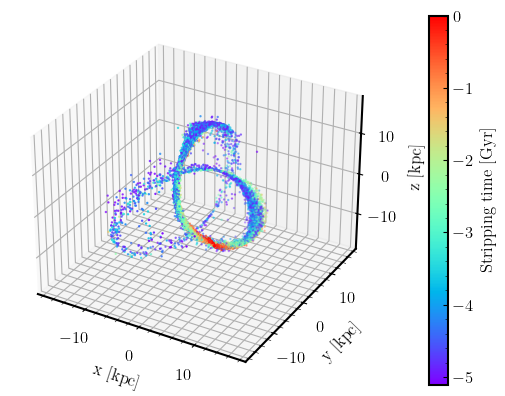

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plt.plot(orbit_sat[:,0], orbit_sat[:,1], orbit_sat[:,2], c='k', alpha=.25)
# plt.plot(orbit_sat[-1][0], orbit_sat[-1][1], orbit_sat[-1][2], '*', ms=20,c='r',)
# plt.plot(xv_stream[:,0], xv_stream[:,1], xv_stream[:,2], 'o', ms=1, mew=0, c='seagreen')
plot=ax.scatter(xv_stream[:,0], xv_stream[:,1], xv_stream[:,2],
            marker='.', c=np.repeat(time_sat[1:],2), cmap='rainbow', s=2, rasterized=True)


ax.set_xlim(-19,19)
ax.set_ylim(-19,19)
ax.set_zlim(-19,19)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')

ax.view_init(azim = -60, elev =30) #azim,: -60, 60

cbar=plt.colorbar(plot, pad=0.1)
cbar.set_label('Stripping time [Gyr]')